Created on December 30th 2020 by Patrick Rotzetter

https://www.linkedin.com/in/rotzetter/

# A few notebooks with various text mining and natural language processing experiments: Part 2
In this second part, we will still use spacy output, but this time we will be using spacy entities as input for a count and tfidf vectorizer. We will show also how we could use clustering to classify documents in an unsupervised learnign way. Since we have only a small number of documents in this experiment, this is not extremely usefull, but this can be used for larger number of documents

In [1]:
#check python version and path
import sys
sys.executable

'/Users/patrickrotzetter/opt/anaconda3/envs/spacy3x/bin/python'

In [2]:
#import main libraries
import numpy as np
import PyPDF2
import spacy
import pandas as pd
import re
from pptx import Presentation
import pdftotext
import texthero as hero

In [3]:
# validate spacy language models just in case, this command does not work on Mac ARM systems unless you have installed the brew workaround and reinstalled python
!python -m spacy validate

/System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: No module named spacy


In [4]:
# function to read PDF files using PYPdf2
def readPdfFilePY(filename):
    text=""
    read_pdf = PyPDF2.PdfFileReader(filename,'rb')   
    for i in range(read_pdf.getNumPages()):
        page = read_pdf.getPage(i)
        txt=page.extractText()
        text=text+txt
    return text


In [5]:
# function to read PDF files using pdftotext
def readPdfFile(filename):
    text=""
    with open(filename, "rb") as f:
        pdf = pdftotext.PDF(f)
        for page in pdf:
            text=text+page
    return text

In [6]:
# function to read PPT files
def readPPTFile(filename):
    text=""  
    prs = Presentation(filename)
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                text=text+shape.text
    text=remove_special_characters(text)
    return text

In [7]:
#path of input folder
path='./sampledocs/pdf/' 

## Process all directory files with spacy

In [8]:
# helper function to process documents in an apply function and return the nlp object
def processDoc(doc):
    return nlp(doc)

In [9]:
# load spacy with large English model

import en_core_web_lg
nlp = en_core_web_lg.load()

## Let us scan the full directory, read PDF and PPT documents, clean them and process them with spacy

In [10]:
# go through the folder and read all pdf and pptx files
docName=[]
docType=[]
docText=[]
docNLP=[]
import glob
list_of_files = glob.glob(path+'*.pdf')           # create the list of file
fileNames=[]
for file_name in list_of_files:
    fileText=readPdfFile(file_name)
    docName.append(file_name)
    docType.append('pdf')
    docText.append(fileText)
list_of_files = glob.glob(path+'*.pptx')           # create the list of file
for file_name in list_of_files:
    fileText=readPPTFile(file_name)
    docName.append(file_name)
    docType.append('ppt')
    docText.append(fileText)
fullDocs = pd.DataFrame({'Name':docName,'Type':docType,'Text':docText})
fullDocs['cleanText']=hero.clean(fullDocs['Text'])
fullDocs['NLP']=fullDocs['cleanText'].apply(processDoc)
print('Number of read files:',fullDocs.shape[0])

Number of read files: 21


In [11]:
 print ("Average length of text:" + str((np.mean(fullDocs['Text'].str.len()))))
 print ("Min length of text:" + str((np.min(fullDocs['Text'].str.len()))))
 print ("Max length of text:" + str((np.max(fullDocs['Text'].str.len()))))

Average length of text:87030.23809523809
Min length of text:9170
Max length of text:328295


In [12]:
fullDocs['text_word_count'] = fullDocs['Text'].apply(lambda x: len(x.strip().split()))  # word count
fullDocs['text_unique_words']=fullDocs['Text'].apply(lambda x:len(set(str(x).split())))  # number of unique words
fullDocs.head()

,Name,Type,Text,cleanText,NLP,text_word_count,text_unique_words
0,./sampledocs/pdf/ai_in_insurance_web_0.pdf,pdf,Promoting Responsible\nArtificial Intelligence...,promoting responsible artificial intelligence ...,"(promoting, responsible, artificial, intellige...",9087,2706
1,./sampledocs/pdf/NIST.IR.8312.pdf,pdf,NISTIR 8312\n\nFour Principles of Explainable ...,nistir four principles explainable artificial ...,"(nistir, four, principles, explainable, artifi...",16792,5026
2,./sampledocs/pdf/ai-360-research.pdf,pdf,AI 360: insights from the\nnext frontier of bu...,ai insights next frontier business corner offi...,"(ai, insights, next, frontier, business, corne...",5281,1746
3,./sampledocs/pdf/Module-1-Lecture-Slides.pdf,pdf,"Application of AI, Insurtech and Real Estate\n...",application ai insurtech real estate technolog...,"(application, ai, insurtech, real, estate, tec...",3728,1506
4,./sampledocs/pdf/Technology-and-innovation-in-...,pdf,Technology and\ninnovation in the\ninsurance s...,technology innovation insurance sector technol...,"(technology, innovation, insurance, sector, te...",16742,4228


## Let use TF-IDF to analyse documents features
Largely inspired by this repository https://buhrmann.github.io/tfidf-analysis.html

In [13]:
# import additional spacy symbols and stop words
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
from spacy.lang.en.stop_words import STOP_WORDS

In [14]:
# instead of using the full text, we will use only certains words detected by spacy
ents=[]
for doc in fullDocs.NLP:
    # all entities
    words=[]
    words += [token.lemma_ for token in doc if token.is_stop != True and token.is_punct != True \
              and token.is_space != True and token.pos != NUM and token.pos != SYM \
              and token.text != '©' and (not token.text in STOP_WORDS)and (not token.lemma_ in STOP_WORDS)]
    ents.append(' '.join(words))
entitiesdf=pd.DataFrame(ents)
entitiesdf.head()

,0
0,promote responsible artificial intelligence in...
1,nistir principle explainable artificial intell...
2,ai insight frontier business corner office cor...
3,application ai insurtech real estate technolog...
4,technology innovation insurance sector technol...


In [15]:
# function to get top n tfidf words in a row
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [16]:
# function to get top n words in a document
def top_features_in_document(mat, features, row_id, top_n=25):
    row = np.squeeze(mat[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [17]:
# function to get top n features that are on average most important in a set of documents
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.2, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [18]:
# Initialize the count vectorizer first
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
cvec = CountVectorizer()
counts=cvec.fit_transform(entitiesdf[entitiesdf.columns[0]])
print('length of vocabulary',len(cvec.vocabulary_))
print ('sparse matrix shape:', counts.shape)
print ('nonzero count:', counts.nnz)
print (' sparsity: %.2f%%' % (100.0 * counts.nnz / (counts.shape[0] * counts.shape[1])))

length of vocabulary 11823
sparse matrix shape: (21, 11823)
nonzero count: 35273
 sparsity: 14.21%


The vocabulary has a 7102 words, and the matrix is at 72% empty

In [19]:
# initialize the tfidf transforme
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 


In [20]:
# transform the count matrix into a tfidf matrix
tfidf = tfidf_transformer.fit_transform(counts)
features = cvec.get_feature_names()

/Users/patrickrotzetter/opt/anaconda3/envs/spacy3x/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
#let us check the top features of document 6 for example
top_features_in_document(tfidf, features, row_id=6, top_n=25)

,feature,tfidf
0,mi,0.754728
1,datum,0.200015
2,model,0.150288
3,swiss,0.144600
4,ml,0.136600
5,sigma,0.125659
6,eg,0.121960
7,insurer,0.114621
8,system,0.100612
9,insurance,0.097564


The words AI, right and EU are the most important topics in this document. This speaks mainly about AI in the conmtext of the EU right 

In [22]:
#let us check the top features of document 3 to compare with the above
top_features_in_document(tfidf, features, row_id=3, top_n=25)

,feature,tfidf
0,insurtech,0.668853
1,insurance,0.207062
2,microinsurance,0.183167
3,q4,0.157616
4,series,0.141301
5,bima,0.123841
6,insurer,0.119673
7,technology,0.118118
8,milken,0.115053
9,investment,0.109254


In this case the document seems to be about insurance, consumer and product. This is not surprising given that most of the documents are about Insurance innovation.

In [23]:
top_mean_feats(tfidf, features, grp_ids=None, min_tfidf=0.3, top_n=25)

,feature,tfidf
0,ai,0.111443
1,insurance,0.106097
2,dataiku,0.039014
3,mi,0.035939
4,insurtech,0.031850
5,explanation,0.028938
6,chatbot,0.028819
7,financial,0.028785
8,bank,0.027690
9,artificial,0.021356


Not surprisingly, top features across documents include insurance, digital and AI, Not sure what 'mi' stands for though. Let us have a deeper look at it below

In [24]:
mi=nlp('mi')
for token in mi:
    print(token.pos_)

ADP


well spacy interprets 'mi' as a preposition, we could set a specific rule if we want to avoid this in our context, but that is a different topic for now

In [25]:
# We can also look at the number of occurences of each term
occ = np.asarray(counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

/Users/patrickrotzetter/opt/anaconda3/envs/spacy3x/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,term,occurrences
392,ai,2129
2653,datum,1729
5462,insurance,1720
11234,use,1073
2551,customer,1004
2626,data,999
10494,technology,907
10380,system,900
9113,risk,894
2955,digital,763


In [26]:
weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

/Users/patrickrotzetter/opt/anaconda3/envs/spacy3x/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,term,weight
392,ai,0.175911
5462,insurance,0.163174
2653,datum,0.144037
2551,customer,0.090836
5475,insurer,0.077383
2626,data,0.075483
10494,technology,0.073102
11234,use,0.069160
9113,risk,0.068588
7180,new,0.060276


In [27]:
tfidf.toarray().shape

(21, 11823)

In [28]:
countsarray = counts.toarray()
tfidfarray=tfidf.toarray()
tfidfaarray = tfidfarray-np.mean(tfidfarray,axis=0)
countsarray = countsarray-np.mean(countsarray,axis=0)
evecs,evalues,V0 =np.linalg.svd(tfidfarray)
evecs

array([[-0.26843062,  0.21647538, -0.27298758,  0.12223556, -0.01745571,
         0.06621429,  0.00901031,  0.04982825,  0.01999212, -0.03571607,
        -0.09697537,  0.08219496, -0.02382362,  0.07666525, -0.16952567,
         0.03799811,  0.59484407, -0.52314151, -0.06146605,  0.28735381,
         0.1266345 ],
       [-0.11533929,  0.32537093, -0.184137  ,  0.25643997, -0.25833246,
         0.62040184,  0.23179159, -0.06219119, -0.20929656, -0.36283798,
        -0.09556766, -0.07280389, -0.00623269,  0.02942246,  0.07337575,
         0.01144332, -0.21475859,  0.14821819,  0.03104617, -0.08098858,
         0.00333382],
       [-0.21679699,  0.19211169,  0.42287389,  0.12944644,  0.12033685,
        -0.05539754, -0.10722074, -0.11436957,  0.19047246, -0.17069469,
         0.14796619,  0.06281254, -0.1258411 ,  0.17218432,  0.61356947,
         0.16502669, -0.14042816, -0.31356617, -0.05886399, -0.02426046,
         0.12589285],
       [-0.16582649, -0.30053988, -0.21344889, -0.00250617

In [29]:
evalues

array([2.57925185, 1.25791742, 1.0778997 , 1.01662661, 0.97750983,
       0.93960687, 0.92537964, 0.91680079, 0.90141383, 0.88077256,
       0.84947968, 0.83652158, 0.79362381, 0.74331942, 0.7285457 ,
       0.70283786, 0.66719028, 0.65277595, 0.61354725, 0.56265049,
       0.50336841])

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5, random_state=42)
tfidfRed= pca.fit_transform(countsarray)
tfidfRed.shape

(21, 5)

In [31]:
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

distortions = []
K = range(1, 5)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(tfidfRed)
    distortions.append(kmeanModel.inertia_)
    print('Processed {} clusters'.format(k))

Processed 1 clusters
Processed 2 clusters
Processed 3 clusters
Processed 4 clusters


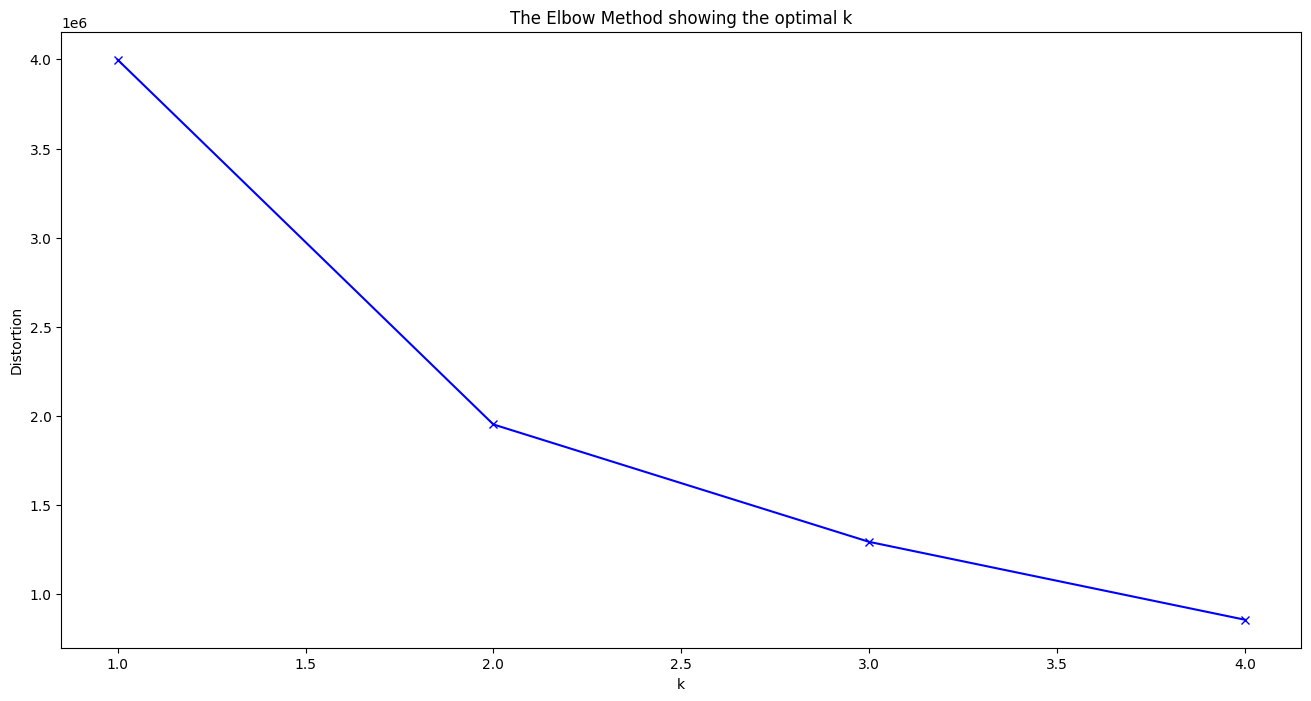

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(tfidfRed)

In [34]:
kmeans.cluster_centers_

array([[ -69.40721637,    5.13567542,    4.11399587,    2.51963082,
          -1.84778025],
       [1388.14432736, -102.71350842,  -82.27991747,  -50.39261645,
          36.95560499]])

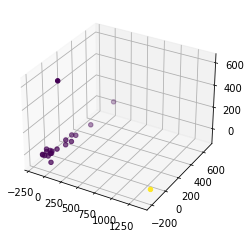

In [35]:
%matplotlib inline  
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(tfidfRed[:,0], tfidfRed[:,1],tfidfRed[:,2], c=pred_y);


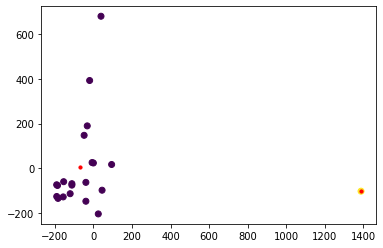

In [36]:
plt.scatter(tfidfRed[:,0], tfidfRed[:,1],c=pred_y)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=10, c='red')
plt.show()

In [37]:
fullDocs[pred_y==1]

,Name,Type,Text,cleanText,NLP,text_word_count,text_unique_words
18,./sampledocs/pdf/fra-2020-artificial-intellige...,pdf,REPORT\n\nGETTING THE\nFUTURE RIGHT\n―\nARTIFI...,report getting future right -- artificial inte...,"(report, getting, future, right, --, artificia...",49748,8458


In [38]:
fullDocs[pred_y==0]

,Name,Type,Text,cleanText,NLP,text_word_count,text_unique_words
0,./sampledocs/pdf/ai_in_insurance_web_0.pdf,pdf,Promoting Responsible\nArtificial Intelligence...,promoting responsible artificial intelligence ...,"(promoting, responsible, artificial, intellige...",9087,2706
1,./sampledocs/pdf/NIST.IR.8312.pdf,pdf,NISTIR 8312\n\nFour Principles of Explainable ...,nistir four principles explainable artificial ...,"(nistir, four, principles, explainable, artifi...",16792,5026
2,./sampledocs/pdf/ai-360-research.pdf,pdf,AI 360: insights from the\nnext frontier of bu...,ai insights next frontier business corner offi...,"(ai, insights, next, frontier, business, corne...",5281,1746
3,./sampledocs/pdf/Module-1-Lecture-Slides.pdf,pdf,"Application of AI, Insurtech and Real Estate\n...",application ai insurtech real estate technolog...,"(application, ai, insurtech, real, estate, tec...",3728,1506
4,./sampledocs/pdf/Technology-and-innovation-in-...,pdf,Technology and\ninnovation in the\ninsurance s...,technology innovation insurance sector technol...,"(technology, innovation, insurance, sector, te...",16742,4228
5,./sampledocs/pdf/AI-bank-of-the-future-Can-ban...,pdf,Global Banking & Securities\n\nAI-bank of the ...,global banking securities ai bank future banks...,"(global, banking, securities, ai, bank, future...",5774,2144
6,./sampledocs/pdf/sigma-5-2020-en.pdf,pdf,No 5 /2020\n\nMachine intelligence in\ninsuran...,machine intelligence insurance insights end en...,"(machine, intelligence, insurance, insights, e...",14478,4329
7,./sampledocs/pdf/WEF_Governance_of_Chatbots_in...,pdf,In collaboration with\nMitsubishi Chemical Hol...,collaboration mitsubishi chemical holdings cor...,"(collaboration, mitsubishi, chemical, holdings...",10301,2941
8,./sampledocs/pdf/ai-insurance.pdf,pdf,"AI in Insurance\nTop Use Cases, Challenges, an...",ai insurance top use cases challenges trends w...,"(ai, insurance, top, use, cases, challenges, t...",6558,2297
9,./sampledocs/pdf/A Guide for Ethical Data Scie...,pdf,A Guide for\nEthical Data Science\n\nA collabo...,guide ethical data science collaboration royal...,"(guide, ethical, data, science, collaboration,...",3482,1193
